In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import NearestNeighbors
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE
# from sklearn.neighbors import NeighborhoodCleaningRule
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load data and make data_dict


# Define dictionary to store arrays
data_dict = {}

# Loop through files in directory
for file_name in os.listdir('D:/Admin/Documents/AI/Lab ISE/Dataset_SOICT2022/Data/dataApache(PROMISE)'):

  # Check if file is in ABC-x.y.csv format
  if '-' in file_name and file_name.endswith('.csv'):
    array_name = file_name.split('-')[0]

  # Check if file is in ABC.csv format
  # elif file_name.endswith('.csv'):
  #   array_name = file_name[:-4]

  # Skip file if not in expected format
  else:
    continue

  # Load file into array
  file_path = os.path.join('D:/Admin/Documents/AI/Lab ISE/Dataset_SOICT2022/Data/dataApache(PROMISE)', file_name)
  data = pd.read_csv(file_path)

  # Add array to dictionary
  if array_name not in data_dict:
    data_dict[array_name] = [data]
    print(array_name)
  else:
    data_dict[array_name].append(data)


FileNotFoundError: ignored

In [ ]:
# if len(data_dict[project_name])<2:

In [ ]:
for project_name in data_dict:
  if len(data_dict[project_name])<=2:
    print(project_name)

prop


In [ ]:
# Concat all data of a project and split label
def make_X_y (project_name):
  project_data = pd.DataFrame()
  for data_version in data_dict[project_name]:
    project_data = pd.concat([project_data, data_version], axis=0)
  # print("project data after concat:")
  # print(project_data)

  # Drop not numerical column
  project_data = project_data.select_dtypes(include = [np.number])
  # print("project data after drop innumerical:")
  # print(project_data)

  # Standardize label column
  label_column_index = project_data.shape[1]-1
  project_data.iloc[:, label_column_index] = project_data.iloc[:, label_column_index].apply(lambda x: 0 if x==0 else 1)
  # print("project data after standardize label:")
  # print(project_data)

  # Split data to X y
  X = project_data.iloc[:, :label_column_index]
  y = project_data.iloc[:, label_column_index]
  print(X)
  print(y)

  return X, y

In [ ]:
# Process with Bayesian
# Process function
def train_evaluate_Bayes (project_name):

  print("Project:"+project_name)

  X, y = make_X_y(project_name)

  # init n_folds
  if len(data_dict[project_name])<2:
    n_folds = 2
  else:
    n_folds = len(data_dict[project_name])

  # init n_folds_search
  if n_folds==2:
    n_folds_search = 2
  else:
    n_folds_search = n_folds-1

  # Create a stratified k-fold object
  # ? can it solve atribute normallization
  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

  # Define the search spaces for each model
  param_space_mlp = {
        'hidden_layer_sizes': Integer(50, 100),
        'activation': ['relu', 'tanh'],
        'alpha': Real(0.0001, 0.01),
  }

  param_space_dt = {
        'max_depth': Integer(1, 15),
        'min_samples_split': Integer(2, 20),
  }

  param_space_rf = {
        'n_estimators': Integer(50, 100),
        'max_depth': Integer(2, 30),
        'min_samples_split': Integer(2, 6),
  }

  param_space_svm = {
        'C': (1e-2, 10),
        'kernel': ['linear', 'rbf'],
        'gamma': ('scale', 'auto'),
  }


  # Define sampling methods
  sampler_names = ['SMOTE', 'NCR']
  samplers = [SMOTE(), NeighbourhoodCleaningRule()]


  # Define models
  model_names = ['MLP', 'Decision Tree', 'Random Forest', 'SVM']
  models = {
      'MLP': (MLPClassifier(max_iter=4000, solver='adam', random_state=42), param_space_mlp),
      'Decision Tree': (DecisionTreeClassifier(random_state=42), param_space_dt),
      'Random Forest': (RandomForestClassifier(random_state=42), param_space_rf),
      'SVM': (SVC(max_iter=4000, random_state=42), param_space_svm)
  }


  # Initialize results dictionary
  results = {name: {sampler_name: [] for sampler_name in sampler_names} for name in model_names}

  # Loop through each fold in the stratified k-fold cross-validation
  for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:", fold+1)

    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # if sample=='NCR':
    #   # Resample the training data to fix class imbalance using Neighborhood Cleaning Rule
    #   ncr = NeighbourhoodCleaningRule()
    #   X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
    # elif sample=='SMOTE':
    #   # Resample the training data to fix class imbalance using SMOTE


    # Initialize scaler
    scaler = StandardScaler()

    # Fit scaler on training data
    scaler.fit(X_train)

    # Scale training and testing data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Loop over sampling methods
    for sampler_name, sampler in zip(sampler_names, samplers):
      # Apply sampling method to training data
      X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_scaled, y_train)
      # Loop over models
      for model_name, (model, param_grid) in models.items():
        print("Model:", model_name)

        # Define the BayesSearchCV object for the model
        model_bayes = BayesSearchCV(model, param_grid, cv=n_folds_search, scoring='f1', n_iter=30, refit=True, random_state=42)

        # Train the model on the resampled training data using BayesSearchCV
        model_bayes.fit(X_train_sampled, y_train_sampled)
        best_params = model_bayes.best_params_

        # Create a new instance of the model using the best hyperparameters
        if model_name == 'MLP':
          estimator_best = MLPClassifier(**model_bayes.best_params_)
        elif model_name == 'Decision Tree':
          estimator_best = DecisionTreeClassifier(**model_bayes.best_params_)
        elif model_name == 'Random Forest':
          estimator_best = RandomForestClassifier(**model_bayes.best_params_)
        elif model_name == 'SVM':
          estimator_best = SVC(**model_bayes.best_params_)

        # Fine-tune the pre-trained model on the unsampled set
        model_bayes.set_params(n_iter=10, estimator=estimator_best)

        model_bayes.fit(X_train_scaled, y_train)

        # Evaluate the model on the testing data using the best hyperparameters found by BayesSearchCV
        y_pred = model_bayes.predict(X_test_scaled)
        f1 = f1_score(y_test, y_pred)
        print("F1 Score:", f1)
        print("Best parameter:", best_params)

        # Add the f1 score to the results dictionary
        results[model_name][sampler_name].append(f1)

  # Calculate average f1_macro of each model and sampling method
  avg_results = {name: {sampler_name: np.mean(results[name][sampler_name]) for sampler_name in sampler_names} for name in model_names}
  # Print the results
  for name in avg_results:
    print(name)
    for sampler_name in avg_results[name]:
      print(f"\t{sampler_name}: {avg_results[name][sampler_name]:.4f}")

  # Plot the results in a bar chart
  fig, ax = plt.subplots(figsize=(8, 6))
  x = np.arange(len(model_names))
  width = 0.35
  for i, sampler_name in enumerate(sampler_names):
    y = [avg_results[name][sampler_name] for name in model_names]
    ax.bar(x + i * width, y, width, label=sampler_name)
  ax.set_ylabel('Average f1')
  ax.set_xticks(x + width / 2)
  ax.set_xticklabels(model_names)
  ax.legend()
  plt.show()
  return avg_results



In [ ]:
!pip uninstall numpy
!pip install "numpy<1.20.0"

^C
^C


In [ ]:
train_evaluate_Bayes('ant')

Project:ant
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3   loc       dam   
0     11    4    2   14   42    29   2  12    5  0.725000   395  1.000000  \
1     14    1    1    8   32    49   4   4   12  0.835165   257  1.000000   
2      3    2    0    1    9     0   0   1    1  0.000000    58  1.000000   
3     12    3    0   12   37    32   0  12   12  0.858586   310  1.000000   
4      6    3    0    4   21     1   0   4    6  0.700000   136  1.000000   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...   ...       ...   
740   92    3    0   34  261  3726   8  34   81  0.960246  2704  0.970588   
741    6    3    6   10   10     3   7   3    6  0.400000    46  1.000000   
742    7    3    5    9   26     0   5   4    6  0.000000   141  1.000000   
743    5    2    0    8   34     8   1   7    3  0.500000   216  1.000000   
744    2    1    0    2   18     0   0   2    2  0.000000    83  1.000000   

     moa       mfa       cam  ic  cbm        amc  max_cc  avg_c

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.43333333333333335
Best parameter: OrderedDict([('activation', 'tanh'), ('alpha', 0.00011902673753624445), ('hidden_layer_sizes', 74)])
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\opt

F1 Score: 0.47887323943661975
Best parameter: OrderedDict([('max_depth', 15), ('min_samples_split', 2)])
Model: Random Forest
F1 Score: 0.4181818181818182
Best parameter: OrderedDict([('max_depth', 21), ('min_samples_split', 2), ('n_estimators', 52)])
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.35789473684210527
Best parameter: OrderedDict([('C', 9.76362370289394), ('gamma', 'auto'), ('kernel', 'rbf')])
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
from ast import mod
# Process function
def train_evaluate (project_name):

  print("Project:"+project_name)

  X, y = make_X_y(project_name)

  # init n_folds
  if len(data_dict[project_name])<2:
    n_folds = 2
  else:
    n_folds = len(data_dict[project_name])

  # init n_folds_search
  if n_folds==2:
    n_folds_search = 2
  else:
    n_folds_search = n_folds-1


  # Create a stratified k-fold object
  # ? can it solve atribute normallization
  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

  # Define hyperparameter search spaces for each model
  param_space_mlp = {
      'hidden_layer_sizes': [(10,), (50,), (100,)],
      'activation': ['relu', 'tanh'],
      'alpha': [1e-5, 1e-2],
  }

  param_space_dt = {
      'max_depth': [0.1, 1, 10],
      'min_samples_split': [2, 8],
  }

  param_space_rf = {
      'n_estimators': [50, 150],
      'max_depth': [7, 9],
      'min_samples_split': [2, 4],
  }

  param_space_svm = {
      'C': [1e-3, 1e3],
      'kernel': ['linear', 'rbf'],
      'gamma': [1e-3, 1e3],
  }

  # # Define function to perform Bayesian optimization
  # def bayesian_optimization(X, y, model, param_space):
  #   def objective(**params):
  #     model.set_params(**params)
  #     # Round the value of hidden_layer_sizes to the nearest integer
  #     params['hidden_layer_sizes'] = round(params['hidden_layer_sizes'])
  #     return -np.mean(cross_val_score(model, X, y, cv=skf, scoring='f1_macro', error_score='raise'))

  #   optimizer = BayesianOptimization(
  #       f=objective,
  #       pbounds=param_space,
  #       random_state=42
  #   )

  #   optimizer.maximize(n_iter=10, init_points=5)

  #   return optimizer.max['params']

  # Define sampling methods
  sampler_names = ['SMOTE', 'NCR']
  samplers = [SMOTE(), NeighbourhoodCleaningRule()]


  # Define models
  models = {
      'MLP': (MLPClassifier(max_iter=4000, solver='adam', random_state=42), param_space_mlp),
      'Decision Tree': (DecisionTreeClassifier(random_state=42), param_space_dt),
      'Random Forest': (RandomForestClassifier(random_state=42), param_space_rf),
      'SVM': (SVC(max_iter=4000, random_state=42), param_space_svm)
  }

  # Initialize results dictionary
  results = {name: {sampler_name: [] for sampler_name in sampler_names} for name in model_names}

  # Loop through each fold in the stratified k-fold cross-validation
  for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:", fold+1)

    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # if sample=='NCR':
    #   # Resample the training data to fix class imbalance using Neighborhood Cleaning Rule
    #   ncr = NeighbourhoodCleaningRule()
    #   X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
    # elif sample=='SMOTE':
    #   # Resample the training data to fix class imbalance using SMOTE


    # Initialize scaler
    scaler = StandardScaler()

    # Fit scaler on training data
    scaler.fit(X_train)

    # Scale training and testing data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Loop over sampling methods
    for sampler_name, sampler in zip(sampler_names, samplers):
      # Apply sampling method to training data
      X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_scaled, y_train)
      # Loop over models
      for model_name, (model, param_grid) in models.items():
        print("Model:", model_name)

        # Define the GridSearchCV object for the model
        grid_search = GridSearchCV(model, param_grid, cv=n_folds_search, scoring='f1', refit=True)

        # Train the model on the resampled training data using GridSearchCV
        grid_search.fit(X_train_sampled, y_train_sampled)

        # Get the best hyperparameter
        best_params = grid_search.best_params_

        # Create a new instance of the model using the best hyperparameters
        if model_name == 'MLP':
          estimator_best = MLPClassifier(**best_params)
        elif model_name == 'Decision Tree':
          estimator_best = DecisionTreeClassifier(**best_params)
        elif model_name == 'Random Forest':
          estimator_best = RandomForestClassifier(**best_params)
        elif model_name == 'SVM':
          estimator_best = SVC(**best_params)

        # Fine-tune the pre-trained model on the unsampled set
        grid_search.set_params(estimator=estimator_best)

        grid_search.fit(X_train_scaled, y_train)

        # Evaluate the model on the testing data using the best hyperparameters found by GridSearchCV
        y_pred = grid_search.predict(X_test_scaled)
        f1 = f1_score(y_test, y_pred)
        print("F1 Score:", f1)
        print("Best parameter:", best_params)

        # Add the f1_macro score to the results dictionary
        results[model_name][sampler_name].append(f1)

  # Calculate average f1_macro of each model and sampling method
  avg_results = {name: {sampler_name: np.mean(results[name][sampler_name]) for sampler_name in sampler_names} for name in model_names}
  # Print the results
  for name in avg_results:
    print(name)
    for sampler_name in avg_results[name]:
      print(f"\t{sampler_name}: {avg_results[name][sampler_name]:.4f}")

  # Plot the results in a bar chart
  fig, ax = plt.subplots(figsize=(8, 6))
  x = np.arange(len(model_names))
  width = 0.35
  for i, sampler_name in enumerate(sampler_names):
    y = [avg_results[name][sampler_name] for name in model_names]
    ax.bar(x + i * width, y, width, label=sampler_name)
  ax.set_ylabel('Average f1')
  ax.set_xticks(x + width / 2)
  ax.set_xticklabels(model_names)
  ax.legend()
  plt.show()
  return avg_results



In [ ]:
# testttttttttttttttttttttt
from ast import mod
# Process function
def train_evaluate_test (project_name, n_folds):

  print("Project:"+project_name)

  X, y = make_X_y(project_name)

  # Create a stratified k-fold object
  # ? can it solve atribute normallization
  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

  # Define hyperparameter search spaces for each model
  param_space_mlp = {
      'hidden_layer_sizes': [(50,), (100,)],
      'alpha': [1e-5, 1e-2],
  }

  param_space_dt = {
      'max_depth': [5, 15],
      'min_samples_split': [2, 8],
  }

  param_space_rf = {
      'n_estimators': [50, 150],
      'max_depth': [7, 9],
      'min_samples_split': [2, 4],
  }

  param_space_svm = {
      'C': [1e-3, 1e3],
      'gamma': [1e-3, 1e3],
  }

  # # Define function to perform Bayesian optimization
  # def bayesian_optimization(X, y, model, param_space):
  #   def objective(**params):
  #     model.set_params(**params)
  #     # Round the value of hidden_layer_sizes to the nearest integer
  #     params['hidden_layer_sizes'] = round(params['hidden_layer_sizes'])
  #     return -np.mean(cross_val_score(model, X, y, cv=skf, scoring='f1_macro', error_score='raise'))

  #   optimizer = BayesianOptimization(
  #       f=objective,
  #       pbounds=param_space,
  #       random_state=42
  #   )

  #   optimizer.maximize(n_iter=10, init_points=5)

  #   return optimizer.max['params']

  # Define sampling methods
  sampler_names = ['SMOTE', 'NCR']
  samplers = [SMOTE(), NeighbourhoodCleaningRule()]


  # Define models
  model_names = ['MLP', 'Decision Tree', 'Random Forest', 'SVM']
  models = {
      'MLP': (MLPClassifier(max_iter=4000), param_space_mlp),
      'Decision Tree': (DecisionTreeClassifier(), param_space_dt),
      'Random Forest': (RandomForestClassifier(), param_space_rf),
      'SVM': (SVC(), param_space_svm)
  }

  # Initialize results dictionary
  results = {name: {sampler_name: [] for sampler_name in sampler_names} for name in model_names}

  # Loop through each fold in the stratified k-fold cross-validation
  for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:", fold+1)

    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # if sample=='NCR':
    #   # Resample the training data to fix class imbalance using Neighborhood Cleaning Rule
    #   ncr = NeighbourhoodCleaningRule()
    #   X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
    # elif sample=='SMOTE':
    #   # Resample the training data to fix class imbalance using SMOTE


    # # Initialize scaler
    # scaler = StandardScaler()

    # # Fit scaler on training data
    # scaler.fit(X_train)

    # # Scale training and testing data
    # X_train_scaled = scaler.transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    # Loop over sampling methods
    for sampler_name, sampler in zip(sampler_names, samplers):
      # Apply sampling method to training data
      X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
      # Loop over models
      for model_name, (model, param_grid) in models.items():
        print("Model:", model_name)

        # Define the GridSearchCV object for the model
        grid_search = GridSearchCV(model, param_grid, cv=n_folds, scoring='f1')

        # Train the model on the resampled training data using GridSearchCV
        grid_search.fit(X_train_sampled, y_train_sampled)

        # Get the best hyperparameter
        best_params = grid_search.best_params_

        # Create a new instance of the model using the best hyperparameters
        if model_name == 'MLP':
          model_best = MLPClassifier(**best_params, random_state = 42)
        elif model_name == 'Decision Tree':
          model_best = DecisionTreeClassifier(**best_params, random_state = 42)
        elif model_name == 'Random Forest':
          model_best = RandomForestClassifier(**best_params, random_state = 42)
        elif model_name == 'SVM':
          model_best = SVC(**best_params, random_state = 42)

        model_best.fit(X_train_sampled, y_train_sampled)

        model_best.fit(X_train, y_train)

        # Evaluate the model on the testing data using the best hyperparameters found by GridSearchCV
        y_pred = model_best.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        print("F1 Score:", f1)
        print("Best parameter:", best_params)

        # Add the f1_macro score to the results dictionary
        results[model_name][sampler_name].append(f1)

  # Calculate average f1_macro of each model and sampling method
  avg_results = {name: {sampler_name: np.mean(results[name][sampler_name]) for sampler_name in sampler_names} for name in model_names}
  # Print the results
  for name in avg_results:
    print(name)
    for sampler_name in avg_results[name]:
      print(f"\t{sampler_name}: {avg_results[name][sampler_name]:.4f}")

  # Plot the results in a bar chart
  fig, ax = plt.subplots(figsize=(8, 6))
  x = np.arange(len(model_names))
  width = 0.35
  for i, sampler_name in enumerate(sampler_names):
    y = [avg_results[name][sampler_name] for name in model_names]
    ax.bar(x + i * width, y, width, label=sampler_name)
  ax.set_ylabel('Average f1_macro')
  ax.set_xticks(x + width / 2)
  ax.set_xticklabels(model_names)
  ax.legend()
  plt.show()
  return avg_results



Project:ant
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3   loc       dam   
0     11    4    2   14   42    29   2  12    5  0.725000   395  1.000000  \
1     14    1    1    8   32    49   4   4   12  0.835165   257  1.000000   
2      3    2    0    1    9     0   0   1    1  0.000000    58  1.000000   
3     12    3    0   12   37    32   0  12   12  0.858586   310  1.000000   
4      6    3    0    4   21     1   0   4    6  0.700000   136  1.000000   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...   ...       ...   
740   92    3    0   34  261  3726   8  34   81  0.960246  2704  0.970588   
741    6    3    6   10   10     3   7   3    6  0.400000    46  1.000000   
742    7    3    5    9   26     0   5   4    6  0.000000   141  1.000000   
743    5    2    0    8   34     8   1   7    3  0.500000   216  1.000000   
744    2    1    0    2   18     0   0   2    2  0.000000    83  1.000000   

     moa       mfa       cam  ic  cbm        amc  max_cc  avg_c

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.39655172413793105
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.47887323943661975
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4464285714285715
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.35416666666666663
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.42372881355932207
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.47887323943661975
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.45454545454545453
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.35416666666666663
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.44230769230769235
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.5333333333333333
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.40366972477064217
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.34782608695652173
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.45098039215686275
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.5333333333333333
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.44247787610619477
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.34782608695652173
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.5042016806722688
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.5428571428571428
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4745762711864407
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.39252336448598124
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.41739130434782606
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.5428571428571428
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4833333333333334
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.39252336448598124
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 4
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4912280701754386
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.6013071895424836
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.49090909090909096
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.45714285714285724
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.5254237288135594
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6013071895424836
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.4778761061946903
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.45714285714285724
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 5
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.47368421052631576
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.5694444444444445
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.37499999999999994
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.32258064516129026
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.33027522935779813
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.5694444444444445
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.37499999999999994
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.32258064516129026
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.4616
	NCR: 0.4296
Decision Tree
	SMOTE: 0.5452
	NCR: 0.5452
Random Forest
	SMOTE: 0.4381
	NCR: 0.4466
SVM
	SMOTE: 0.3748
	NCR: 0.3748


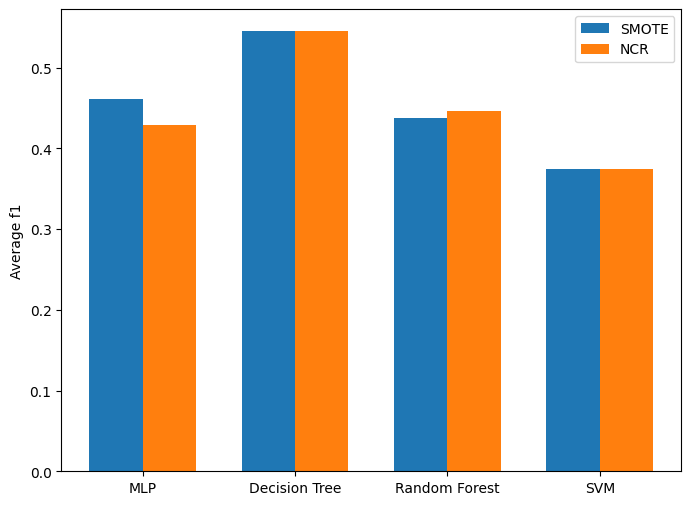

Project:camel
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3  loc  dam  moa   
0      4    2    0    6    8     6   2   5    4  2.000000   26  0.0    0  \
1      6    3    0   21   33    15   1  21    2  2.000000  176  0.0    0   
2      2    3    0    3    7     1   0   3    1  2.000000   24  0.0    0   
3     26    1    1   10   47     0   5   5   24  0.080000  236  1.0    1   
4      4    3    0    4   19     6   1   4    3  2.000000   62  0.0    0   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...  ...  ...  ...   
960    6    1    0    4   13     0   3   2    6  0.000000   46  1.0    1   
961    3    1    0    4   19     3   4   0    2  1.500000  201  0.0    0   
962    3    2    0    8   16     3   1   7    2  2.000000   44  0.0    0   
963   12    1    3    8   25    46   6   7    8  0.454545  102  0.0    1   
964    4    1    0    2    5     0   1   2    4  0.666667   28  1.0    2   

          mfa       cam  ic  cbm        amc  max_cc  avg_cc  
0    0.8965

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.2914572864321608
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.25742574257425743
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.2543352601156069
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.12738853503184713
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.3054187192118227
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.2926829268292683
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.21839080459770113
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.12738853503184713
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.32460732984293195
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.3238095238095238
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.21686746987951805
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.10596026490066225
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.3402061855670103
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.33816425120772947
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.20606060606060606
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.10596026490066225
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.3880597014925373
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.2590673575129534
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.2598870056497175
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.16766467065868262
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.38190954773869346
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.23280423280423282
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.25842696629213485
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.16766467065868262
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 4
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.3005181347150259
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.3055555555555556
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.21052631578947367
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.10191082802547771
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.3316582914572865
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.28703703703703703
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.23529411764705885
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.10191082802547771
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.3262
	NCR: 0.3398
Decision Tree
	SMOTE: 0.2865
	NCR: 0.2877
Random Forest
	SMOTE: 0.2354
	NCR: 0.2295
SVM
	SMOTE: 0.1257
	NCR: 0.1257


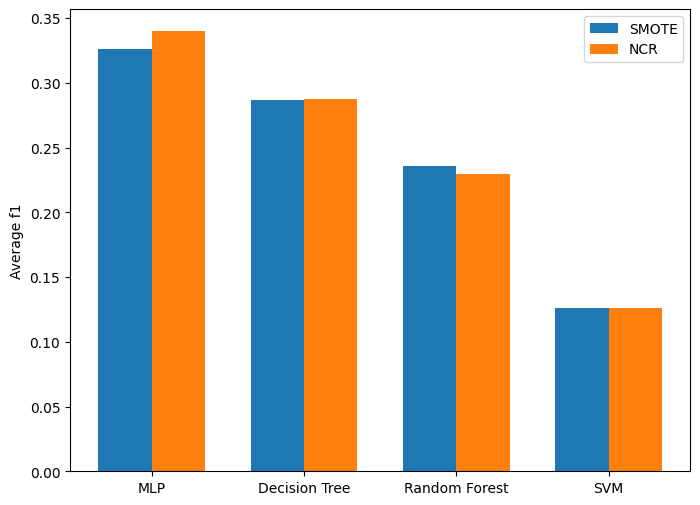

Project:ivy
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3   loc    dam  moa   
0      2    1    0    8    2     1   7   1    2  2.000000     2  0.000    0  \
1     23    1    0    7   52   171   2   5   20  0.837662   420  1.000    2   
2      4    1    0   10    4     6   9   1    4  2.000000     4  0.000    0   
3     13    4    2   17   57    22   2  15    9  0.250000   346  1.000    1   
4     38    2    0   37  153   569   1  37   21  0.895270  1515  0.875    1   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...   ...    ...  ...   
347    3    1    0   15    3     3  14   1    3  2.000000     3  0.000    0   
348    8    1    0   18   17    20  17   1    8  0.464286   141  1.000    1   
349   10    1    0   15   10    45  12   3   10  2.000000    10  0.000    0   
350   45    4    0   13  113   814   1   0   45  0.943723   636  1.000    0   
351    7    1    0   10   44    19   4   7    4  0.916667   348  0.500    0   

          mfa       cam  ic  cbm       

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.16000000000000003
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.32941176470588235
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.12
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.04444444444444445
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.17857142857142858
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.275
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.16000000000000003
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.04444444444444445
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.15384615384615383
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.35714285714285715
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.12
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.13636363636363635
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.24
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.34567901234567905
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.1176470588235294
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.13636363636363635
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.163265306122449
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.22535211267605634
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.16666666666666666
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.13043478260869565
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.2222222222222222
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.26666666666666666
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.16666666666666666
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.13043478260869565
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.1590
	NCR: 0.2136
Decision Tree
	SMOTE: 0.3040
	NCR: 0.2958
Random Forest
	SMOTE: 0.1356
	NCR: 0.1481
SVM
	SMOTE: 0.1037
	NCR: 0.1037


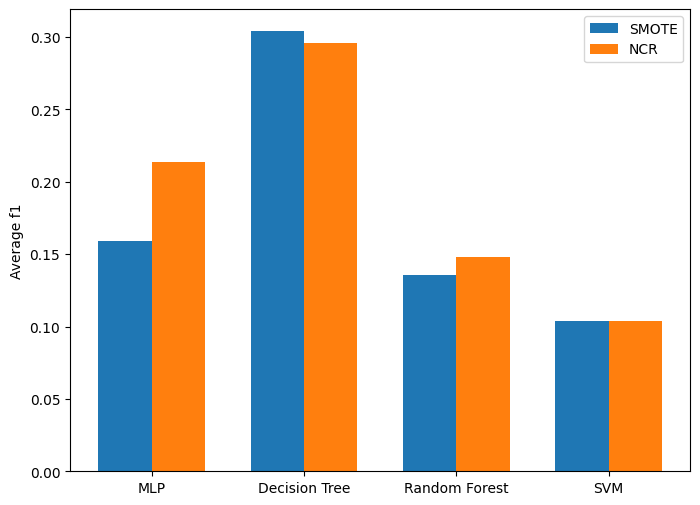

Project:jedit
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3  loc  dam  moa   
0     14    1    0    9   45    61   3   6   11  0.769231  425  1.0    1  \
1      7    2    0    4   21     0   1   3    0  0.541667  300  1.0    1   
2      6    1    0    3   11     9   1   3    5  0.600000  113  1.0    3   
3      6    2    0   16   14     3   8   8    5  0.666667   92  1.0    0   
4      5    2    0    5   22     0   1   4    0  0.125000  206  1.0    0   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...  ...  ...  ...   
487   11    2    1   12   54    25   1  11    5  0.300000  444  1.0    1   
488    3    2    0    5    9     0   3   2    3  0.000000   36  1.0    0   
489    3    3    1    7    5     3   4   3    2  2.000000   19  0.0    0   
490    2    2    0    1    4     1   0   1    2  2.000000   16  0.0    0   
491   10    1    0   18   33     7   9  11    5  0.685185  207  0.0    2   

          mfa       cam  ic  cbm        amc  max_cc  avg_cc  
0    0.0000

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4367816091954023
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.3877551020408163
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.3855421686746988
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.11940298507462686
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.3809523809523809
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.34693877551020413
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.3902439024390244
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.11940298507462686
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.5098039215686274
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.39669421487603307
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.48936170212765956
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.29729729729729726
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4782608695652174
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.4132231404958678
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.46464646464646464
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.29729729729729726
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.456140350877193
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4081632653061225
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.1917808219178082
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4468085106382978
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.4
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.411764705882353
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.1917808219178082
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 4
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4166666666666667
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.3269230769230769
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4421052631578947
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.1515151515151515
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.41237113402061853
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.3302752293577982
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.43010752688172044
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.1515151515151515
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 5
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.3181818181818182
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.3762376237623763
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.33707865168539325
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.16216216216216217
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.32183908045977017
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.3877551020408163
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.27272727272727276
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.16216216216216217
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.4163
	NCR: 0.4080
Decision Tree
	SMOTE: 0.3888
	NCR: 0.3756
Random Forest
	SMOTE: 0.4125
	NCR: 0.3939
SVM
	SMOTE: 0.1844
	NCR: 0.1844


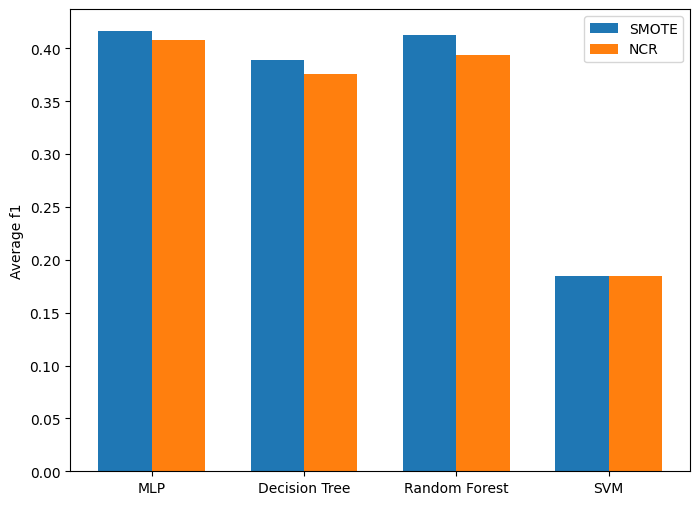

Project:log4j
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3  loc       dam  moa   
0      4    4    0    3   12     6   2   1    4  2.000000   99  0.000000    0  \
1      2    1    0    0    3     1   0   0    2  2.000000    6  0.000000    0   
2      8    1    0    6   22     0   3   3    8  0.142857  176  1.000000    0   
3      8    2    1    7   24    12   1   6    8  0.936508  179  0.555556    0   
4     10    1    5   34   13    45  32   2    9  1.000000   28  0.000000    0   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...  ...       ...  ...   
200   10    2    0    6   38     9   0   6    6  0.747475  327  0.000000    2   
201   11    2    1    7   27    19   1   6   11  0.911111  198  0.555556    0   
202    8    1    0    7   42    14   0   7    2  0.750000  308  0.000000    2   
203    7    3    0    5   19     7   1   5    4  0.777778   74  0.333333    1   
204    4    1    0    2   17     6   1   1    4  2.000000   53  0.000000    0   

          mfa

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6863905325443787
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.6249999999999999
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.5813953488372092
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.6889952153110047
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6815642458100558
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", li

F1 Score: 0.5828571428571429
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.6889952153110047
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6631016042780749
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6455696202531646
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.6198830409356725
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.7341772151898733
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6666666666666667
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6127167630057804
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.6432748538011697
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.7341772151898733
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6455696202531647
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6836734693877551
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.5868263473053892
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.673076923076923
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6787878787878788
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6836734693877551
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.5895953757225434
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.673076923076923
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.6650
	NCR: 0.6757
Decision Tree
	SMOTE: 0.6514
	NCR: 0.6321
Random Forest
	SMOTE: 0.5960
	NCR: 0.6052
SVM
	SMOTE: 0.6987
	NCR: 0.6987


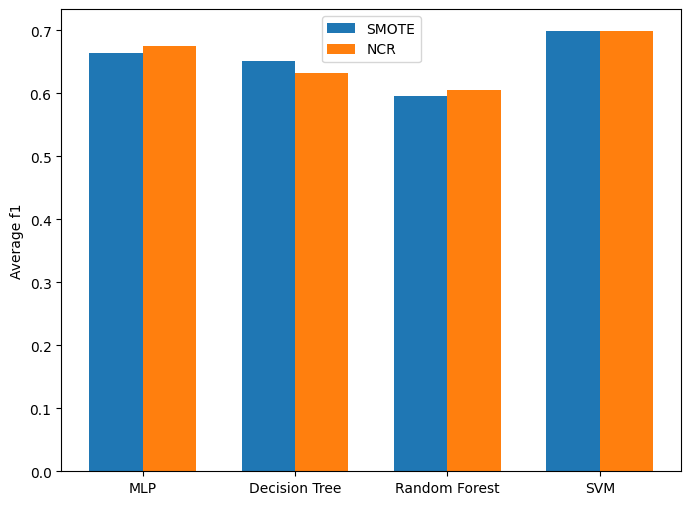

Project:lucene
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3   loc  dam  moa   
0      2    2    0    3    4     1   0   3    2  2.000000    10  0.0    0  \
1     10    1    0    4   37     0   0   4    9  0.388889   278  1.0    0   
2     27    1    0    1   43    13   1   0   13  0.600962  1174  1.0    0   
3      1    1    0   21    1     0  20   1    1  2.000000     1  0.0    0   
4      3    1    2   19    4     3  18   1    3  2.000000     7  0.0    0   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...   ...  ...  ...   
335   13    3    0    6   29    38   2   4   11  0.716667   178  0.6    1   
336   16    1    0    3   24     0   2   2   12  0.383333   361  1.0    2   
337    7    2    0    3   10    21   3   1    7  2.000000    54  0.0    0   
338   10    2    0   24   37     7   9  18    4  0.759259   276  0.0    8   
339    3    4    0    6    6     3   3   5    0  2.000000    22  0.0    0   

          mfa       cam  ic  cbm        amc  max_cc  avg_cc 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6956521739130435
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6666666666666666
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6983050847457627
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7065217391304348
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6912751677852349
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6381578947368421
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6953642384105961
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.7065217391304348
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6938775510204082
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6099290780141843
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.6802721088435374
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7302452316076294
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.7090301003344482
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.606896551724138
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6910299003322259
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.7302452316076294
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.7422680412371134
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.6015037593984963
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.7132867132867133
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7192118226600985
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.7353951890034365
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6353790613718412
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.7137809187279152
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7192118226600985
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.7106
	NCR: 0.7119
Decision Tree
	SMOTE: 0.6260
	NCR: 0.6268
Random Forest
	SMOTE: 0.6973
	NCR: 0.7001
SVM
	SMOTE: 0.7187
	NCR: 0.7187


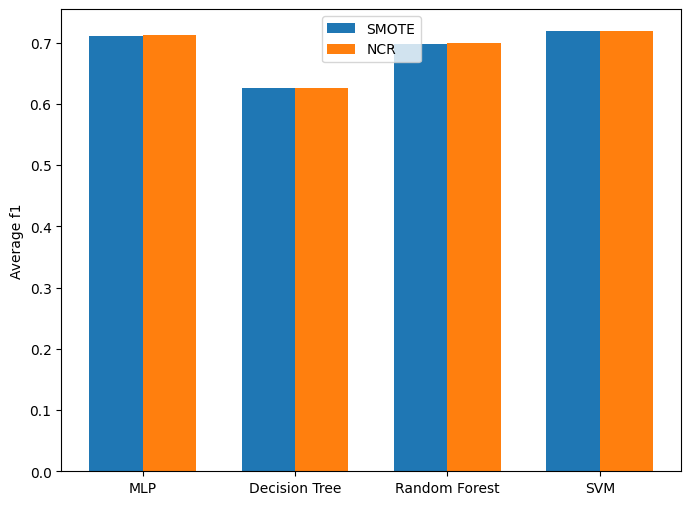

Project:poi
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3  loc       dam  moa   
0     25    2    0    6   44   128   1   5   23  0.948864  429  0.363636    3  \
1     20    2    0    4   36   138   1   4   20  0.846890  336  0.909091    7   
2     23    2    0    8   48   235   2   6   21  0.924242  379  0.444444    0   
3     22    2    0    5   41   159   2   3   18  0.702381  325  0.750000    0   
4      4    4    0    3    8     6   2   1    4  2.000000   20  0.000000    0   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...  ...       ...  ...   
437    6    1    2    5   13     0   2   3    4  0.500000  107  1.000000    2   
438    7    3    0    1   18    21   1   0    7  1.149123  301  0.052632    2   
439   21    2    5   14   42    38   8   7   20  0.685714  318  0.857143    3   
440   10    2    0    6   24    33   2   4    8  0.777778  166  0.000000    0   
441    3    4    2    3    4     0   2   1    3  0.500000   21  1.000000    0   

          mfa  

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6648351648351648
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6091954022988506
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6811989100817439
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.6751918158567775
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.664864864864865
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.6091954022988506
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6794520547945205
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.6751918158567775
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.711340206185567
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6814814814814815
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6756756756756755
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7104622871046229
Best parameter: {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6987341772151898
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6814814814814815
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.6736842105263158
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7104622871046229
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6811989100817439
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.6844919786096256
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6914893617021277
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.6989795918367347
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6898395721925134
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6844919786096256
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6790450928381963
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.6989795918367347
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 4
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.679245283018868
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6565656565656566
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.663013698630137
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.671957671957672
Best parameter: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.664819944598338
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6565656565656566
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.6703296703296703
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.671957671957672
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.6842
	NCR: 0.6796
Decision Tree
	SMOTE: 0.6579
	NCR: 0.6579
Random Forest
	SMOTE: 0.6778
	NCR: 0.6756
SVM
	SMOTE: 0.6891
	NCR: 0.6891


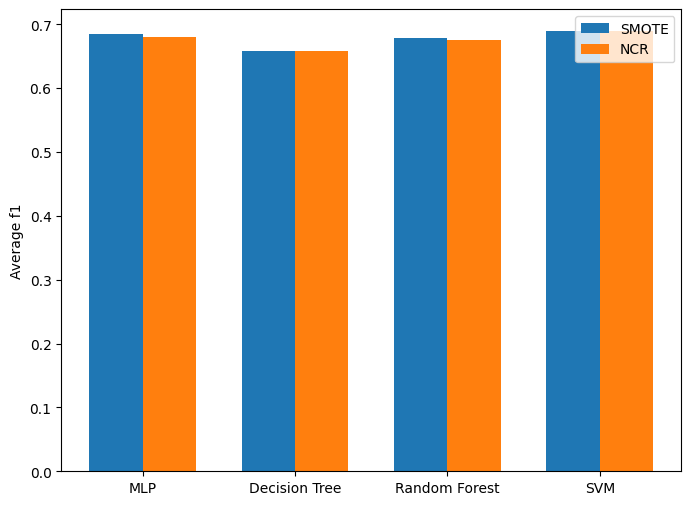

Project:prop
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm    lcom3  loc  dam  moa   
0      2    2    0    5    9     1   1   4    1  2.00000   49  0.0    0  \
1      3    1    0    1    3     3   1   0    3  2.00000    3  0.0    0   
2     13    2    0    8   17    78   0   8   13  2.00000   49  0.0    0   
3      2    2    0    5    7     1   1   4    1  2.00000   17  0.0    0   
4     23    1    0   10   23   253   2   8   23  2.00000   23  0.0    0   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...      ...  ...  ...  ...   
639    9    2    0   10   20    36   5  10    9  2.00000   80  0.0    0   
640    6    2    0    7   15    15   2   7    6  2.00000   46  0.0    0   
641    6    1    0    5   29    11   2   4    4  0.60000  169  0.0    0   
642    6    1    0    3   31     1   1   2    3  0.50000  203  1.0    1   
643   29    1    0   11   50   180  10   1   26  0.72619  418  1.0    0   

          mfa       cam  ic  cbm        amc  max_cc  avg_cc  
0    0.909091  0.750000 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.18867924528301885
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.303030303030303
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.2692307692307692
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.15789473684210525
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.1923076923076923
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.34285714285714286
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.2692307692307692
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.15789473684210525
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'linear'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.05714285714285715
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.18867924528301885
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.21739130434782608
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.14634146341463417
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.05555555555555555
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.22222222222222224
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.17777777777777776
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.14634146341463417
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.1229
	NCR: 0.1239
Decision Tree
	SMOTE: 0.2459
	NCR: 0.2825
Random Forest
	SMOTE: 0.2433
	NCR: 0.2235
SVM
	SMOTE: 0.1521
	NCR: 0.1521


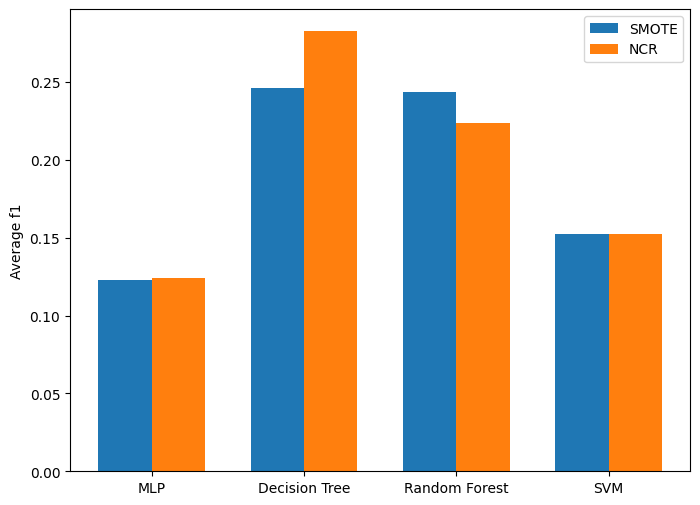

Project:synapse
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3  loc       dam  moa   
0      6    1    0   12   65     3   1  11    2  0.700000  585  0.500000    0  \
1      4    3    0    5    9     4   0   5    3  0.666667   30  1.000000    0   
2      5    2    0   11   41     6   0  11    3  0.846154  423  0.923077    0   
3      6    1    0    6   22     0   4   3    5  0.000000  154  1.000000    0   
4      1    1    0    9    1     0   8   1    1  2.000000    1  0.000000    0   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...  ...       ...  ...   
251    7    1    0    9   22     5   0   9    7  0.700000  114  1.000000    1   
252    3    2    0   10   21     3   0  10    3  2.000000  107  0.000000    0   
253   15    1    0   23   75    49  10  13   10  0.285714  940  1.000000    0   
254    4    2    0    4   10     4   1   4    1  0.666667   43  1.000000    1   
255    6    1    0    3   15     0   1   2    6  0.500000   60  1.000000    1   

          m

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4941176470588235
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.5178571428571428
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.39080459770114945
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.39436619718309857
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.3896103896103896
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.5178571428571428
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4175824175824176
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.39436619718309857
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4395604395604396
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.42
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.47826086956521735
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.41463414634146345
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.449438202247191
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.38
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4044943820224719
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.41463414634146345
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4651162790697674
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.0
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.41304347826086957
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.4050632911392405
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4878048780487805
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.4509803921568628
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.42105263157894735
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.4050632911392405
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.4663
	NCR: 0.4423
Decision Tree
	SMOTE: 0.3126
	NCR: 0.4496
Random Forest
	SMOTE: 0.4274
	NCR: 0.4144
SVM
	SMOTE: 0.4047
	NCR: 0.4047


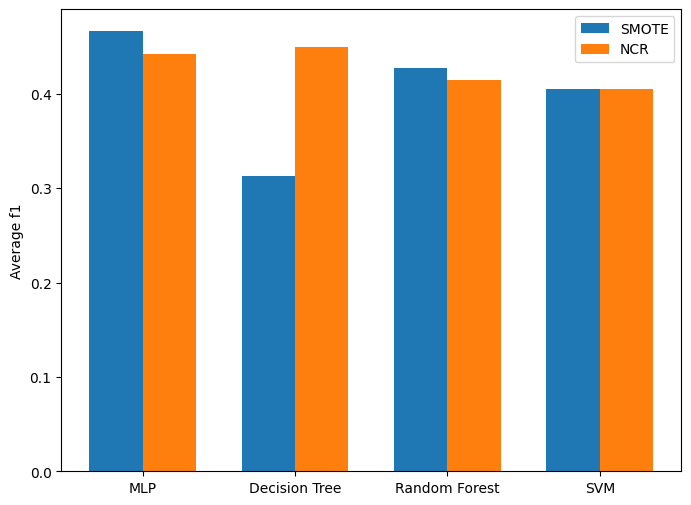

Project:velocity
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3   loc       dam   
0      5    1    0   34    5    10  34   0    5  2.000000     5  0.000000  \
1      1    3    0    1    9     0   0   1    1  2.000000    27  0.000000   
2      3    4    0    8   17     1   0   8    3  0.000000    75  1.000000   
3    148    1    0   60  236     0  43  55   48  0.733909  9104  0.769231   
4      8    1    0   17   44    18   3  17    7  0.761905   360  0.666667   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...   ...       ...   
224    4    1    0    6   10     6   1   5    4  2.000000    34  0.000000   
225    5    2    0    9   13     8   4   7    5  0.750000    41  1.000000   
226   25    1    0   54   25   300  47   7   25  2.000000    25  0.000000   
227    3    1    0    6    3     3   2   4    3  1.500000     5  0.000000   
228    7    1    0    2   14     0   0   2    7  0.416667    63  1.000000   

     moa       mfa       cam  ic  cbm        amc  max_cc  

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.72
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6416666666666667
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.7121212121212122
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.7290969899665553
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6956521739130435
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6416666666666667
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6901960784313725
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7290969899665553
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.7101449275362318
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.7413127413127414
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.7545787545787546
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.756578947368421
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.7218045112781954
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.7413127413127414
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.7500000000000001
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.756578947368421
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6440677966101694
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.641025641025641
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6610169491525425
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.6986301369863014
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6808510638297871
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.6153846153846154
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.6527196652719667
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 Score: 0.6986301369863014
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.6914
	NCR: 0.6994
Decision Tree
	SMOTE: 0.6747
	NCR: 0.6661
Random Forest
	SMOTE: 0.7092
	NCR: 0.6976
SVM
	SMOTE: 0.7281
	NCR: 0.7281


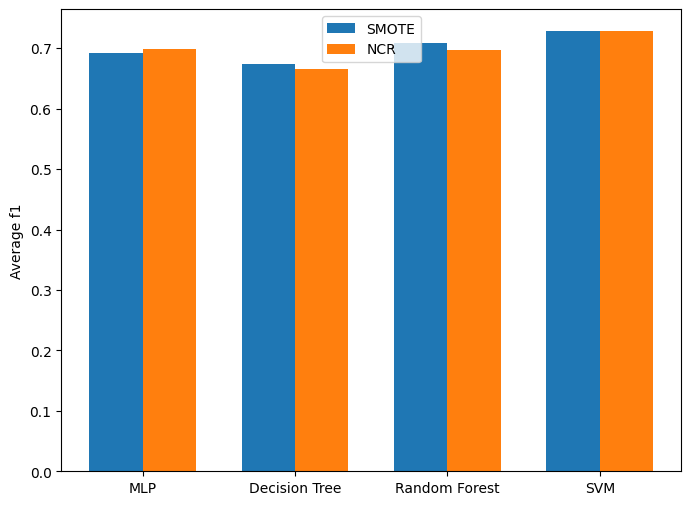

Project:xalan
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3   loc    dam  moa   
0     16    3    0    6   52   112   1   5   11  0.777778   509  1.000    0  \
1     12    2   14   23   23     0  17   8   12  0.363636   149  1.000    2   
2     53    1    0   34  150  1362  22  15   49  1.001603  2089  0.375    0   
3     49    3    2   43  100  1176  34  12   46  1.000000   743  0.000    1   
4      1    1    0    5    1     0   5   1    1  2.000000     1  0.000    0   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...   ...    ...  ...   
904   11    1    1    2   20    53   2   1    0  0.900000    90  1.000    0   
905    5    5    0    5   16     8   0   5    3  1.250000    86  0.000    0   
906    2    4    0    5    7     1   0   5    2  2.000000   614  0.000    0   
907   10    1    0    5   21    45   0   5   10  2.000000   116  0.000    0   
908   25    1    0   90   48   214  88   9   24  0.891667   494  1.000    1   

          mfa       cam  ic  cbm     

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6462984723854288
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6244131455399061
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.6275862068965516
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.6966490299823632
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6575342465753424
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6208530805687204
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6336405529953917
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.6966490299823632
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6370875995449373
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6376811594202898
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6242905788876277
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7004081632653061
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.654945054945055
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6354515050167223
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6286353467561521
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7004081632653061
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6674473067915692
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6377858002406738
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6896551724137931
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.706342991386061
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6578947368421053
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6377858002406738
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6902857142857144
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.706342991386061
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 4
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6826608505997819
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6613816534541336
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.7050847457627119
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7051482059282372
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.6865342163355409
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6568848758465012
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.698876404494382
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.7051482059282372
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.6584
	NCR: 0.6642
Decision Tree
	SMOTE: 0.6403
	NCR: 0.6377
Random Forest
	SMOTE: 0.6617
	NCR: 0.6629
SVM
	SMOTE: 0.7021
	NCR: 0.7021


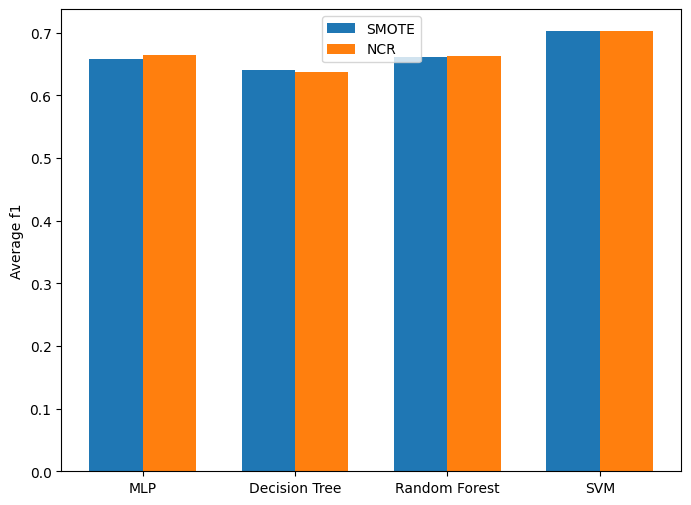

Project:xerces
     wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm     lcom3   loc       dam   
0      8    4    0    0   14     0   0   0    8  0.428571    98  1.000000  \
1     21    1    0    6   35    68   1   5   12  0.677273  1458  0.727273   
2      1    1    0    4    1     0   3   1    1  2.000000     1  0.000000   
3     56    2    2   20  207   778   4  17   37  0.856643  4705  0.961538   
4      5    2    0    3    8    10   1   3    5  1.250000    25  0.000000   
..   ...  ...  ...  ...  ...   ...  ..  ..  ...       ...   ...       ...   
583    0    1    0    2    0     0   1   1    0  2.000000     0  0.000000   
584   12    2    0    9   39    20   2   7   10  0.626263   568  0.888889   
585    6    1    0    7   12     0   1   6    6  0.766667   246  1.000000   
586   12    1    0   10   18     0  10   0   11  0.054545   517  0.000000   
587    6    3    0    8   19    15   2   6    3  2.000000   149  0.000000   

     moa       mfa       cam  ic  cbm        amc  max_cc  av

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4888888888888889
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.4676258992805756
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.46743295019157083
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.3744292237442922
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4925373134328359
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.46209386281588444
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4351145038167939
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.3744292237442922
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Fold: 2
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.4015151515151515
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.34959349593495936
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4316546762589928
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.35684647302904565
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.43478260869565216
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.34959349593495936
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.4492753623188406
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.35684647302904565
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Fold: 3
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.45925925925925926
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.41568627450980394
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.41897233201581024
Best parameter: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.28037383177570097
Best parameter: {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.44357976653696496
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.39682539682539686
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.43724696356275305
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.28037383177570097
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Fold: 4
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.49635036496350354
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.39840637450199207
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.4981949458483754
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.3181818181818182
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
Model: MLP


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

F1 Score: 0.5147058823529412
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (10,)}
Model: Decision Tree
F1 Score: 0.39840637450199207
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4654545454545455
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\U

F1 Score: 0.3181818181818182
Best parameter: {'C': 1000.0, 'gamma': 1000.0, 'kernel': 'rbf'}
MLP
	SMOTE: 0.4615
	NCR: 0.4714
Decision Tree
	SMOTE: 0.4078
	NCR: 0.4017
Random Forest
	SMOTE: 0.4541
	NCR: 0.4468
SVM
	SMOTE: 0.3325
	NCR: 0.3325


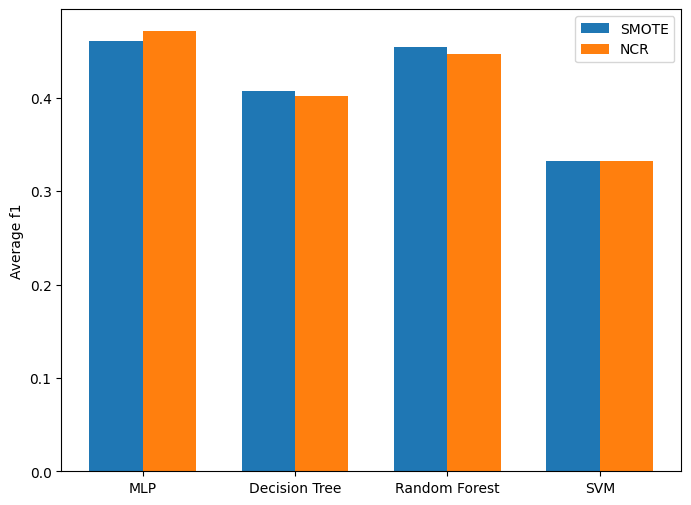

In [ ]:
# Main
import csv

# Define the list of model names and sampler names
model_names = ['MLP', 'Decision Tree', 'Random Forest', 'SVM']
sampler_names = ['SMOTE', 'NCR']


# Define the output file name
output_file = 'output.csv'

with open(output_file, mode='w', newline='') as file:
  writer = csv.writer(file)
  header_row = ['Model', 'Sampling Method']
  for project_name in data_dict:
    header_row.append(project_name+'F1 score')
  header_row.append('Mean F1')
  writer.writerow(header_row)

  results_list = []

  for project_name in data_dict:
    results = train_evaluate(project_name)
    results_list.append(results)


  for model_name in model_names:
    for sampler_name in sampler_names:
      row = [model_names, sampler_name]
      f1_project = []
      for results in results_list:
        f1_scr = results[model_name][sampler_name]
        f1_project.append(f1_scr)
        row.append(f1_scr)
      mean_f1 = np.mean(f1_project)
      row.append(mean_f1)
      writer.writerow(row)


In [ ]:
# Define the fix output file name
output_file = 'fix_output.csv'

with open(output_file, mode='w', newline='') as file:
  writer = csv.writer(file)
  header_row = ['Model', 'Sampling Method']
  for project_name in data_dict:
    header_row.append(project_name+' F1')
  header_row.append('Mean F1')
  writer.writerow(header_row)


  for model_name in model_names:
    for sampler_name in sampler_names:
      row = [model_name, sampler_name]
      f1_project = []
      for results in results_list:
        f1_scr = results[model_name][sampler_name]
        f1_project.append(f1_scr)
        row.append(f1_scr)
      mean_f1 = np.mean(f1_project)
      row.append(mean_f1)
      writer.writerow(row)

Fold: 1
Model: MLP
F1 Score: 0.6463983310835686
Best parameter: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.6143023643023644
Best parameter: {'max_depth': 15, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6447171119459537
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM
F1 Score: 0.5302217242599363
Best parameter: {'C': 1000.0, 'gamma': 0.001}
Model: MLP
F1 Score: 0.6866524108436228
Best parameter: {'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.6629261363636363
Best parameter: {'max_depth': 5, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6665806742877411
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM
F1 Score: 0.5302217242599363
Best parameter: {'C': 1000.0, 'gamma': 0.001}
Fold: 2
Model: MLP
F1 Score: 0.6616130198915009
Best parameter: {'alpha': 1e-05, 'hidden_layer_sizes': (100,)}
Model: Decision Tree
F1 Score: 0.5

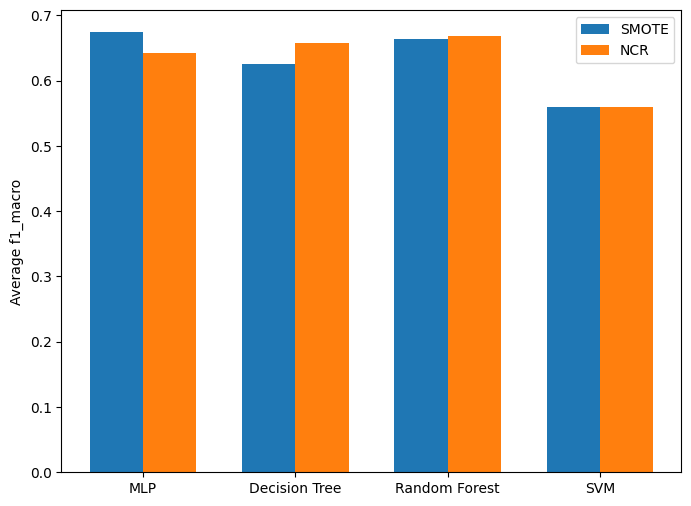

In [ ]:
# Process
train_evaluate(X, y, 5)

Fold: 1
Model: MLP
F1 Score: 0.6143901778459873
Best parameter: {'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6143023643023644
Best parameter: {'max_depth': 15, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6806085412000926
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM
F1 Score: 0.5302217242599363
Best parameter: {'C': 1000.0, 'gamma': 0.001}
Model: MLP
F1 Score: 0.6143901778459873
Best parameter: {'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.6629261363636363
Best parameter: {'max_depth': 5, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.6806085412000926
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM
F1 Score: 0.5302217242599363
Best parameter: {'C': 1000.0, 'gamma': 0.001}
Fold: 2
Model: MLP
F1 Score: 0.6975314761574304
Best parameter: {'alpha': 1e-05, 'hidden_layer_sizes': (50,)}
Model: Decision Tree
F1 Score: 0.563529

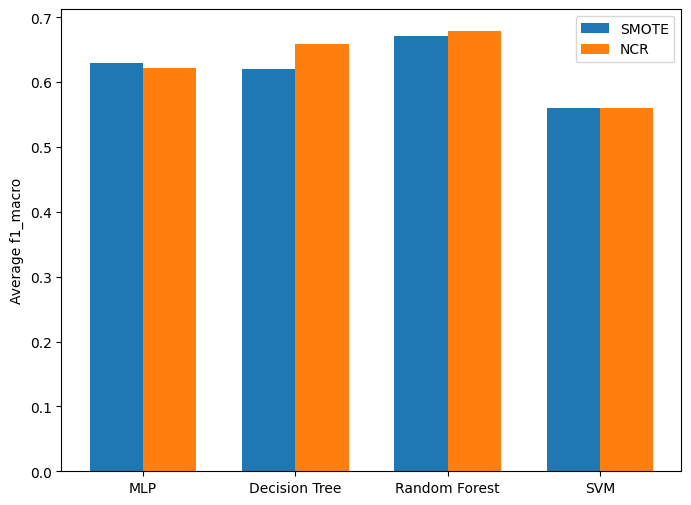

In [ ]:
# Process 2nd time
train_evaluate(X, y, 5)

In [ ]:
from ast import mod
# Process function test
def train_evaluate_test (X, y, n_folds):

  # Create a stratified k-fold object
  # ? can it solve atribute normallization
  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

  # Define hyperparameter search spaces for each model
  param_space_mlp = {
      'hidden_layer_sizes': [(10,), (50,), (100,)],
      'activation': ['relu', 'tanh'],
      'solver': ['adam', 'sgd'],
      'alpha': [1e-5, 1e-2],
  }

  param_space_dt = {
      'max_depth': [0.1, 1, 10],
      'min_samples_split': [2, 8],
  }

  param_space_rf = {
      'n_estimators': [50, 150],
      'max_depth': [7, 9],
      'min_samples_split': [2, 4],
  }

  param_space_svm = {
      'C': [1e-3, 1e3],
      'kernel': ['linear', 'rbf'],
      'gamma': [1e-3, 1e3],
  }

  # # Define function to perform Bayesian optimization
  # def bayesian_optimization(X, y, model, param_space):
  #   def objective(**params):
  #     model.set_params(**params)
  #     # Round the value of hidden_layer_sizes to the nearest integer
  #     params['hidden_layer_sizes'] = round(params['hidden_layer_sizes'])
  #     return -np.mean(cross_val_score(model, X, y, cv=skf, scoring='f1_macro', error_score='raise'))

  #   optimizer = BayesianOptimization(
  #       f=objective,
  #       pbounds=param_space,
  #       random_state=42
  #   )

  #   optimizer.maximize(n_iter=10, init_points=5)

  #   return optimizer.max['params']

  # Define sampling methods
  sampler_names = ['SMOTE', 'NCR']
  samplers = [SMOTE(), NeighbourhoodCleaningRule()]


  # Define models
  model_names = ['MLP', 'Decision Tree', 'Random Forest', 'SVM']
  models = {
      'MLP': (MLPClassifier(max_iter=4000), param_space_mlp),
      'Decision Tree': (DecisionTreeClassifier(), param_space_dt),
      'Random Forest': (RandomForestClassifier(), param_space_rf),
      'SVM': (SVC(max_iter=4000), param_space_svm)
  }

  # Initialize results dictionary
  results = {name: {sampler_name: [] for sampler_name in sampler_names} for name in model_names}

  # Loop through each fold in the stratified k-fold cross-validation
  for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:", fold+1)

    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # if sample=='NCR':
    #   # Resample the training data to fix class imbalance using Neighborhood Cleaning Rule
    #   ncr = NeighbourhoodCleaningRule()
    #   X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
    # elif sample=='SMOTE':
    #   # Resample the training data to fix class imbalance using SMOTE


    # # Initialize scaler
    # scaler = StandardScaler()

    # # Fit scaler on training data
    # scaler.fit(X_train)

    # # Scale training and testing data
    # X_train_scaled = scaler.transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    # Loop over sampling methods
    for sampler_name, sampler in zip(sampler_names, samplers):
      # Apply sampling method to training data
      X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
      # Loop over models
      for model_name, (model, param_grid) in models.items():
        print("Model:", model_name)

        # Define the GridSearchCV object for the model
        grid_search = GridSearchCV(model, param_grid, cv=n_folds, scoring='f1')

        # Train the model on the resampled training data using GridSearchCV
        grid_search.fit(X_train_sampled, y_train_sampled)

        # Get the best hyperparameter
        best_params = grid_search.best_params_

        # Create a new instance of the model using the best hyperparameters
        if model_name == 'MLP':
          model_best = MLPClassifier(**best_params)
        elif model_name == 'Decision Tree':
          model_best = DecisionTreeClassifier(**best_params)
        elif model_name == 'Random Forest':
          model_best = RandomForestClassifier(**best_params)
        elif model_name == 'SVM':
          model_best = SVC(**best_params)

        model_best.fit(X_train_sampled, y_train_sampled)

        model_best.fit(X_train, y_train)

        # Evaluate the model on the testing data using the best hyperparameters found by GridSearchCV
        y_pred = model_best.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        print("F1 Score:", f1)
        print("Best parameter:", best_params)

        # Add the f1_macro score to the results dictionary
        results[model_name][sampler_name].append(f1)

  # Calculate average f1_macro of each model and sampling method
  avg_results = {name: {sampler_name: np.mean(results[name][sampler_name]) for sampler_name in sampler_names} for name in model_names}
  # Print the results
  for name in avg_results:
    print(name)
    for sampler_name in avg_results[name]:
      print(f"\t{sampler_name}: {avg_results[name][sampler_name]:.4f}")

  # Plot the results in a bar chart
  fig, ax = plt.subplots(figsize=(8, 6))
  x = np.arange(len(model_names))
  width = 0.35
  for i, sampler_name in enumerate(sampler_names):
    y = [avg_results[name][sampler_name] for name in model_names]
    ax.bar(x + i * width, y, width, label=sampler_name)
  ax.set_ylabel('Average f1')
  ax.set_xticks(x + width / 2)
  ax.set_xticklabels(model_names)
  ax.legend()
  plt.show()



Fold: 1
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.4247787610619469
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.3728813559322034
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.40366972477064217
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.22950819672131148
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.39285714285714285
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.47887323943661975
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4464285714285715
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.36170212765957444
Best parameter: {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
Fold: 2
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.4181818181818182
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.31496062992125984
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.39639639639639646
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.3529411764705882
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.3619047619047619
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.5333333333333333
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4339622641509434
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.3529411764705882
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.41441441441441446
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.4122137404580153
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.5081967213114755
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.28346456692913385
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP
F1 Score: 0.4247787610619469
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.5428571428571428
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4745762711864407
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.3962264150943397
Best parameter: {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
Fold: 4
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.39252336448598124
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.39655172413793105
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.4912280701754386
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.2764227642276423
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP
F1 Score: 0.32258064516129026
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'solver': 'sgd'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.6013071895424836
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.5087719298245614
Best parameter: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.42424242424242425
Best parameter: {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
Fold: 5
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.4247787610619469
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.45161290322580644
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.3571428571428571
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.24347826086956526
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.4067796610169492
Best parameter: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.39682539682539686
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.39655172413793105
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.24347826086956526
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.4149
	NCR: 0.3818
Decision Tree
	SMOTE: 0.3896
	NCR: 0.5106
Random Forest
	SMOTE: 0.4313
	NCR: 0.4521
SVM
	SMOTE: 0.2772
	NCR: 0.3557


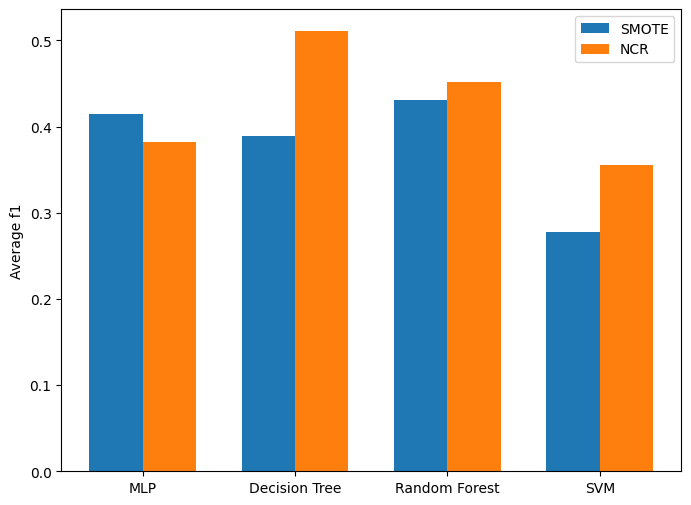

In [ ]:
# Process test
train_evaluate_test(X, y, 5)

In [ ]:
from ast import mod
# Process function test another
def train_evaluate_test (X, y, n_folds):

  # Create a stratified k-fold object
  # ? can it solve atribute normallization
  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

  # Define hyperparameter search spaces for each model
  param_space_mlp = {
      'hidden_layer_sizes': [(10,), (50,), (100,)],
      'activation': ['relu', 'tanh'],
      'solver': ['adam', 'sgd'],
      'alpha': [1e-5, 1e-2],
  }

  param_space_dt = {
      'max_depth': [0.1, 1, 10],
      'min_samples_split': [2, 8],
  }

  param_space_rf = {
      'n_estimators': [50, 150],
      'max_depth': [7, 9],
      'min_samples_split': [2, 4],
  }

  param_space_svm = {
      'C': [1e-3, 1e3],
      'kernel': ['linear', 'rbf'],
      'gamma': [1e-3, 1e3],
  }

  # # Define function to perform Bayesian optimization
  # def bayesian_optimization(X, y, model, param_space):
  #   def objective(**params):
  #     model.set_params(**params)
  #     # Round the value of hidden_layer_sizes to the nearest integer
  #     params['hidden_layer_sizes'] = round(params['hidden_layer_sizes'])
  #     return -np.mean(cross_val_score(model, X, y, cv=skf, scoring='f1_macro', error_score='raise'))

  #   optimizer = BayesianOptimization(
  #       f=objective,
  #       pbounds=param_space,
  #       random_state=42
  #   )

  #   optimizer.maximize(n_iter=10, init_points=5)

  #   return optimizer.max['params']

  # Define sampling methods
  sampler_names = ['SMOTE', 'NCR']
  samplers = [SMOTE(), NeighbourhoodCleaningRule()]


  # Define models
  model_names = ['MLP', 'Decision Tree', 'Random Forest', 'SVM']
  models = {
      'MLP': (MLPClassifier(max_iter=4000), param_space_mlp),
      'Decision Tree': (DecisionTreeClassifier(), param_space_dt),
      'Random Forest': (RandomForestClassifier(), param_space_rf),
      'SVM': (SVC(max_iter=4000), param_space_svm)
  }

  # Initialize results dictionary
  results = {name: {sampler_name: [] for sampler_name in sampler_names} for name in model_names}

  # Loop through each fold in the stratified k-fold cross-validation
  for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:", fold+1)

    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # if sample=='NCR':
    #   # Resample the training data to fix class imbalance using Neighborhood Cleaning Rule
    #   ncr = NeighbourhoodCleaningRule()
    #   X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
    # elif sample=='SMOTE':
    #   # Resample the training data to fix class imbalance using SMOTE


    # Initialize scaler
    scaler = StandardScaler()

    # Fit scaler on training data
    scaler.fit(X_train)

    # Scale training and testing data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Loop over sampling methods
    for sampler_name, sampler in zip(sampler_names, samplers):
      # Apply sampling method to training data
      X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_scaled, y_train)
      # Loop over models
      for model_name, (model, param_grid) in models.items():
        print("Model:", model_name)

        # Define the GridSearchCV object for the model
        grid_search = GridSearchCV(model, param_grid, cv=n_folds, scoring='f1')

        # Train the model on the resampled training data using GridSearchCV
        grid_search.fit(X_train_sampled, y_train_sampled)

        # Get the best hyperparameter
        best_params = grid_search.best_params_

        # Create a new instance of the model using the best hyperparameters
        if model_name == 'MLP':
          model_best = MLPClassifier(**best_params)
        elif model_name == 'Decision Tree':
          model_best = DecisionTreeClassifier(**best_params)
        elif model_name == 'Random Forest':
          model_best = RandomForestClassifier(**best_params)
        elif model_name == 'SVM':
          model_best = SVC(**best_params)

        model_best.fit(X_train_sampled, y_train_sampled)

        model_best.fit(X_train_scaled, y_train)

        # Evaluate the model on the testing data using the best hyperparameters found by GridSearchCV
        y_pred = model_best.predict(X_test_scaled)
        f1 = f1_score(y_test, y_pred)
        print("F1 Score:", f1)
        print("Best parameter:", best_params)

        # Add the f1_macro score to the results dictionary
        results[model_name][sampler_name].append(f1)

  # Calculate average f1_macro of each model and sampling method
  avg_results = {name: {sampler_name: np.mean(results[name][sampler_name]) for sampler_name in sampler_names} for name in model_names}
  # Print the results
  for name in avg_results:
    print(name)
    for sampler_name in avg_results[name]:
      print(f"\t{sampler_name}: {avg_results[name][sampler_name]:.4f}")

  # Plot the results in a bar chart
  fig, ax = plt.subplots(figsize=(8, 6))
  x = np.arange(len(model_names))
  width = 0.35
  for i, sampler_name in enumerate(sampler_names):
    y = [avg_results[name][sampler_name] for name in model_names]
    ax.bar(x + i * width, y, width, label=sampler_name)
  ax.set_ylabel('Average f1')
  ax.set_xticks(x + width / 2)
  ax.set_xticklabels(model_names)
  ax.legend()
  plt.show()



Fold: 1
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.41025641025641024
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.3559322033898305
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.45045045045045046
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.32
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/pytho

F1 Score: 0.4137931034482759
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree
F1 Score: 0.47887323943661975
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.43697478991596644
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.32
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 2
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.42
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.3464566929133858
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.3829787234042553
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/pytho

F1 Score: 0.45871559633027525
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Model: Decision Tree
F1 Score: 0.5333333333333333
Best parameter: {'max_depth': 1, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.41509433962264153
Best parameter: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.3829787234042553
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 3
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.47863247863247865
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.4210526315789474
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4878048780487805
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.36538461538461536
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.4666666666666667
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.4210526315789474
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.47933884297520657
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.36538461538461536
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 4
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.4915254237288136
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.4201680672268908
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.4915254237288136
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.40816326530612246
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/pytho

F1 Score: 0.47058823529411764
Best parameter: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree
F1 Score: 0.4132231404958677
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.5043478260869566
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 50}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.40816326530612246
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Fold: 5
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score: 0.37168141592920345
Best parameter: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Model: Decision Tree


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_par

F1 Score: 0.40322580645161293
Best parameter: {'max_depth': 10, 'min_samples_split': 2}
Model: Random Forest
F1 Score: 0.3793103448275862
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.26666666666666666
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Model: MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/pytho

F1 Score: 0.3636363636363637
Best parameter: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Model: Decision Tree
F1 Score: 0.42187500000000006
Best parameter: {'max_depth': 10, 'min_samples_split': 8}
Model: Random Forest
F1 Score: 0.37606837606837606
Best parameter: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 150}
Model: SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-

F1 Score: 0.26666666666666666
Best parameter: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
MLP
	SMOTE: 0.4344
	NCR: 0.4347
Decision Tree
	SMOTE: 0.3894
	NCR: 0.4537
Random Forest
	SMOTE: 0.4418
	NCR: 0.4424
SVM
	SMOTE: 0.3486
	NCR: 0.3486


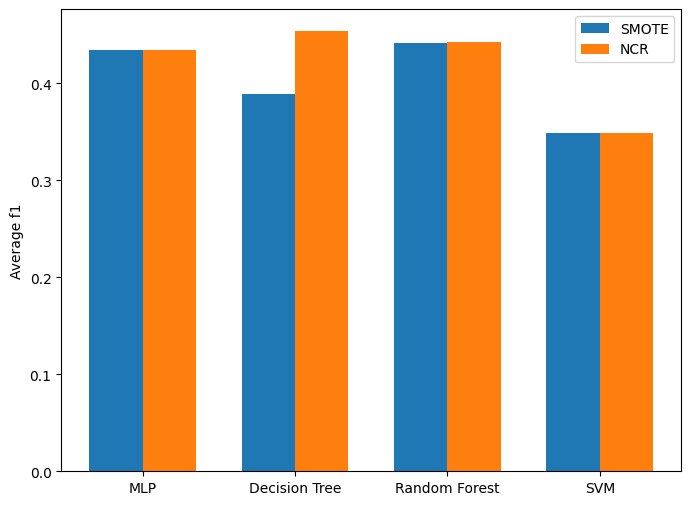

In [ ]:
# Process test
train_evaluate_test(X, y, 5)

In [ ]:




    # Define the hyperparameter grid for MLP
    param_grid = {
        'hidden_layer_sizes': [(10,), (50,), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['lbfgs', 'sgd'],
        'max_iter': [500, 700, 900]
    }

    # Define the models to train and their corresponding hyperparameter grid
    models = {
        'MLP': (MLPClassifier(), param_grid),
        'SVM': (SVC(), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}),
        'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [5, 10, 15], 'criterion':['gini', 'entropy'], 'min_samples_split': [2, 4, 6]}),
        'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 150], 'max_depth': [5, 7, 9], 'min_samples_split': [2, 4, 6]})
    }

    # Train and evaluate each model using GridSearchCV
    for model_name, (model, param_grid) in models.items():
      print("Model:", model_name)

      # Define the GridSearchCV object for the model
      grid_search = GridSearchCV(model, param_grid, cv=n_folds, scoring='f1_macro')

      # Train the model on the resampled training data using GridSearchCV
      grid_search.fit(X_resampled, y_resampled)

      # Evaluate the model on the testing data using the best hyperparameters found by GridSearchCV
      y_pred = grid_search.predict(X_test)
      f1 = f1_score(y_test, y_pred, average='macro')
      print("F1 Score:", f1)
      print("Best parameter:", grid_search.best_params_)

      # Add the f1 score to the list of scores for this fold
      f1_scores.append(f1)
  print(f1_scores)

In [ ]:
# Calculate the average f1 score of each model over all folds
MLP_f1, SVM_f1, DecisionTree_f1, RandomForest_f1 = [], [], [], []
for i in range(0,5):
  MLP_f1.append(f1_scores[i*4])
  SVM_f1.append(f1_scores[i*4+1])
  DecisionTree_f1.append(f1_scores[i*4+2])
  RandomForest_f1.append(f1_scores[i*4+3])
print(MLP_f1)

f1_average = {}
f1_average['MLP'] = (sum(MLP_f1)/len(MLP_f1))
f1_average['SVM'] = (sum(SVM_f1)/len(SVM_f1))
f1_average['DecisionTree'] = (sum(DecisionTree_f1)/len(DecisionTree_f1))
f1_average['RandomForest'] = (sum(RandomForest_f1)/len(RandomForest_f1))
print(f1_average)

[0.7032389845345783, 0.6702836987473195, 0.6885896527285613, 0.6944249121044701, 0.6887549480381253]
{'MLP': 0.6890584392306109, 'SVM': 0.6949057285229966, 'DecisionTree': 0.6683851653703421, 'RandomForest': 0.6851347314298858}


In [ ]:
# Visualize metrics

df_model = pd.DataFrame(index = f1_average.keys(), columns = ['F1_macro'])
df_model['F1_macro'] = f1_average.values()

df_model

,F1_macro
MLP,0.689058
SVM,0.694906
DecisionTree,0.668385
RandomForest,0.685135


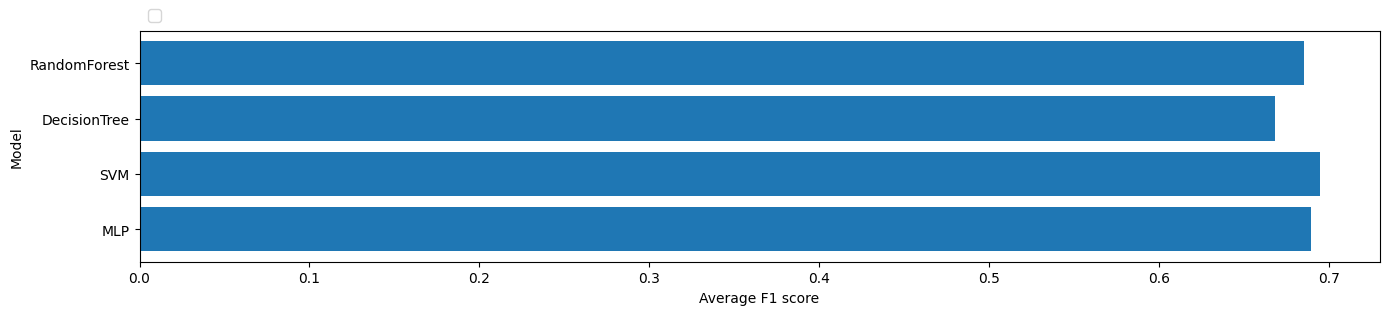

<Figure size 2000x1200 with 0 Axes>

In [ ]:
# Visualize metrics by bar chart

fig, ax = plt.subplots(figsize=(16, 3))
ax.barh(list(f1_average.keys()), list(f1_average.values()))
ax.set_xlabel('Average F1 score')
ax.set_ylabel('Model')
plt.figure(figsize=(10, 6), dpi=200)
# ax = df_model.plot.barh()
ax.legend(
    ncol=len(f1_average.keys()),
    bbox_to_anchor=(0, 1),
    loc='lower left',
    prop={'size': 12}
)

plt.tight_layout()
plt.show()